# This notebook illustrates how to generate stochastic light curves for AGN using Amoeba

Start with standard imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

# I still need to make this work with pip install
import sys

sys.path.append("/Users/henrybest/PythonStuff/Code/Amoeba/")
from amoeba.Classes.accretion_disk import AccretionDisk
from amoeba.Util.util import (
    create_maps,
    generate_signal_from_psd,
    convolve_signal_with_transfer_function,
)
from scipy.signal import convolve

Define some AGN parameters. 

The most important parameters are the mass exponent and eddington ratio. Also relatively important are the number of gravitational radii (how large you want to calculate the disk out to), the resolution (how many pixels are calculated between r=0 and r=r_out), redshift, and the inclination angle (effects skewness of transfer functions).

In [2]:
mass_exponent = 8.5  # solution to log_{10} (M / M_{sun})
number_grav_radii = 1000  # 1k-2k is reasonable for optical wavelengths
inclination = 20  # degrees
resolution = 1000
eddington_ratio = 0.05  # thin disk isn't good for eddington ratios greater than ~0.3
redshift = 3.2

In [3]:
accretion_disk_params = create_maps(
    mass_exponent,
    redshift,
    number_grav_radii,
    inclination,
    resolution,
    eddington_ratio=eddington_ratio,
    name="My accretion disk",
)
Disk = AccretionDisk(**accretion_disk_params)

You can calculate the transfer functions directly from this accretion disk object

In [4]:
tf_300_nm = Disk.construct_accretion_disk_transfer_function(300)
tf_800_nm = Disk.construct_accretion_disk_transfer_function(800)

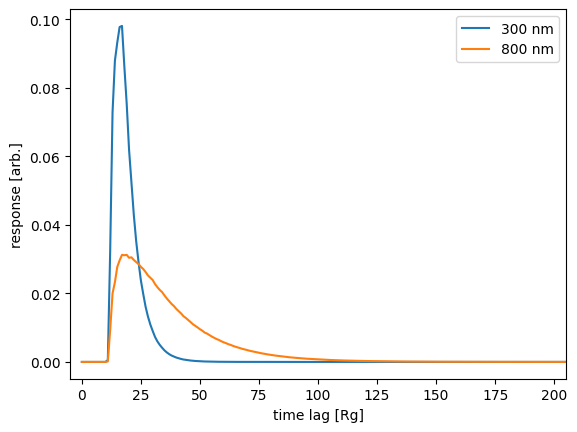

In [5]:
fig, ax = plt.subplots()

ax.plot(tf_300_nm, label="300 nm")
ax.plot(tf_800_nm, label="800 nm")
ax.set_xlabel("time lag [Rg]")
ax.set_ylabel("response [arb.]")
ax.legend(loc=1)
ax.set_xlim(-5, 205)
plt.show()

We can generate signals as well following arbitrary power spectra

In [6]:
t_max = 5000  # days
# define fourier frequencies
frequencies = np.linspace(1 / (2 * t_max), 1 / 2, t_max)

# for DRW, you can define the power spectrum from SF_inf and characteristic timescale
sf_inf = 300
timescale = 20

psd_drw = (4 * timescale * sf_inf**2) / (1 + (2 * np.pi * timescale * frequencies) ** 2)

In [8]:
my_drw_signal = generate_signal_from_psd(
    t_max,
    psd_drw,
    frequencies,
)
second_drw = generate_signal_from_psd(
    t_max,
    psd_drw,
    frequencies,
)
print(np.mean(my_drw_signal.real))
print(np.std(my_drw_signal))

-2.2737367544323207e-17
1.0


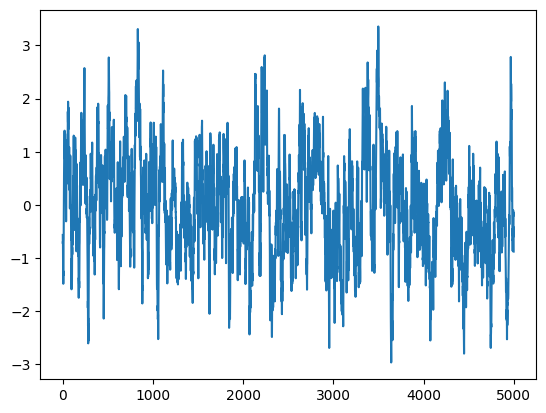

In [9]:
plt.plot(my_drw_signal)

The standard deviation should be set to something reasonable. A large study on ~800k Gaia AGN has been conducted here (https://ui.adsabs.harvard.edu/abs/2024ApJS..274...27M/abstract)

The mean of the light curves may be arbitrarily set, while the standard deviation may be drawn from some distribution (e.g. fig 1)

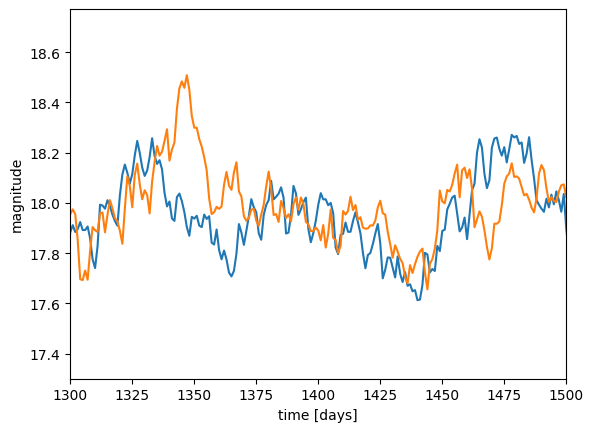

In [10]:
new_standard_dev = 0.21
new_mean = 18

my_drw_signal *= new_standard_dev
my_drw_signal += new_mean

second_drw *= new_standard_dev
second_drw += new_mean

fig, ax = plt.subplots()
ax.plot(my_drw_signal)
ax.plot(second_drw)
ax.set_xlabel("time [days]")
ax.set_ylabel("magnitude")
ax.set_xlim(1300, 1500)
plt.show()

To get correlated variabilities, this driving signal must be convolved with the transfer functions generated by the disk. 

Transfer functions are spaced in gravitational radii, so they must be changed to units of days

In [15]:
obs_frame_300_nm = convolve_signal_with_transfer_function(
    mass_exponent=mass_exponent,
    driving_signal=my_drw_signal,
    transfer_function=tf_300_nm,
    redshift=redshift,
)
obs_frame_800_nm = convolve_signal_with_transfer_function(
    mass_exponent=mass_exponent,
    driving_signal=my_drw_signal,
    transfer_function=tf_800_nm,
    redshift=redshift,
)

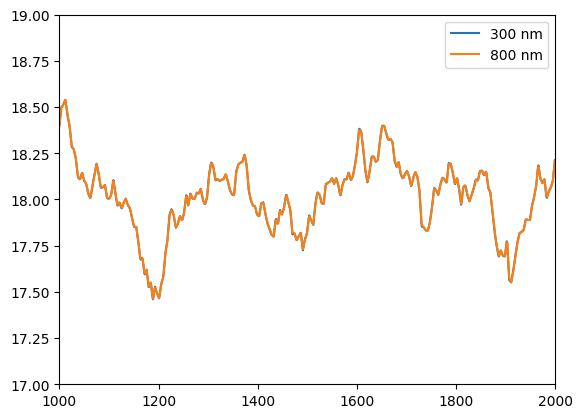

In [22]:
fig, ax = plt.subplots()
ax.plot(obs_frame_300_nm, label="300 nm")
ax.plot(obs_frame_800_nm, label="800 nm")

ax.set_ylim(17, 19)
ax.set_xlim(1000, 2000)
plt.legend()
plt.show()